In [1]:
import numpy as np 
# import torch 
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.lines as lines


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares


def locate(rays):
    """
    From: https://math.stackexchange.com/questions/2598811/calculate-the-point-closest-to-multiple-rays
    Determine the closest point to an arbitrary number of rays, and optionally plot the results

    :param rays:    list of ray tuples (S, D) where S is the starting point & D is a unit vector
    :return:        scipy.optimize.OptimizeResult object from scipy.optimize.least_squares call
    """

    # Generate a starting position, the dimension-wise mean of each ray's starting position
    ray_start_positions = []
    for ray in rays:
        ray_start_positions.append(ray[0])
    starting_P = np.stack(ray_start_positions).mean(axis=0).ravel()

    # Start the least squares algorithm, passing the list of rays to our error function
    ans = least_squares(distance, starting_P, kwargs={'rays': rays})

    return ans

def locate_pinv(rays):
    """
    From: https://math.stackexchange.com/questions/36398/point-closest-to-a-set-four-of-lines-in-3d/55286#55286
    Determine the closest point to an arbitrary number of rays, and optionally plot the results

    :param rays:    list of ray tuples (S, D) where S is the starting point & D is a unit vector
    :return:        scipy.optimize.OptimizeResult object from scipy.optimize.least_squares call
    """

    A_list = []
    p_list = []
    for ray in rays:
        w_i = ray[0][...,None] # (2,1)
        u_i = ray[1][...,None] # (2,1)
        I = np.eye(2)
        A_i = (I - u_i@u_i.T) # (2,1)
        p_i = A_i@w_i # (2,1)

        A_list.append(A_i)
        p_list.append(p_i)
    A = np.array(A_list).sum(0)
    p = np.array(p_list).sum(0)
    A_pinv = np.linalg.pinv(A)
    
    ans = {}
    closest_pt = A_pinv@p # (2,1)
    ans['x'] = closest_pt[:,0]
    return ans



def distance(P, rays):
    """
    Calculate the distance between a point and each ray

    :param P:       1xd array representing coordinates of a point
    :param rays:    list of ray tuples (S, D) where S is the starting point & D is a unit vector
    :return:        nx1 array of closest distance from point P to each ray in rays
    """

    dims = len(rays[0][0])

    # Generate array to hold calculated error distances
    errors = np.full([len(rays)*dims], np.inf)

    # For each ray, calculate the error and put in the errors array
    for i, _ in enumerate(rays):
        S, D = rays[i]
        t_P = D.dot((P - S).T)/(D.dot(D.T))
        if t_P > 0:
            errors[i*dims:(i+1)*dims] = (P - (S + t_P * D)).T
        else:
            errors[i*dims:(i+1)*dims] = (P - S).T

    # Convert the error array to a vector (vs a nx1 matrix)
    return errors.ravel()

ray1 = (np.array([0,0,0]), np.array([0,1,0]))
# ray2 = (np.array([0,0,0]), np.array([0,1,0]))
ray2 = (np.array([1,1,1]), np.array([1,0,0]))
rays = [ray1, ray2]

point = locate(rays)
print("Found point {} with error {} and success {}".format(point['x'], point['cost'], point['success']))
point

Found point [0.5 1.  0.5] with error 0.5 and success True


 active_mask: array([0., 0., 0.])
        cost: 0.5
         fun: array([ 0.5,  0. ,  0.5, -0.5,  0. , -0.5])
        grad: array([2.22044605e-16, 0.00000000e+00, 2.22044605e-16])
         jac: array([[1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 2
        njev: 2
  optimality: 2.220446049250313e-16
      status: 1
     success: True
           x: array([0.5, 1. , 0.5])

In [3]:
def add_circle(ax, X, r, color, fill=True, alpha=1.0, zorder=None):
    x, y = X
    if zorder is None:
        ax.add_artist(Circle((x, y,),r, fill = fill, color=color, alpha=alpha))        
    else:
        ax.add_artist(Circle((x, y,),r, fill = fill, color=color, zorder=zorder, alpha=alpha))
    return ax

def ray_circle_intersection2d(O, e_, Cs, r):
    # Define ray
#     O = np.array([0, 0])
#     e_ = np.array([1, m])
    e_ = e_/np.linalg.norm(e_)
    
    # Intersection
    OC_ = Cs - O
    t = np.dot(OC_, e_)
    Pe = O + e_*t
    d = np.linalg.norm(Pe - Cs)
    
    # Draw intersections
    if(d == r):
        Ps = Pe
        return Ps, Ps, d, d, True
    if(d < r):
        i = (r**2 - d**2)**0.5
        Ps1 = O + e_*(t - i)
        Ps2 = O + e_*(t + i)
        return Ps1, Ps2, np.linalg.norm(Ps1 - Cs), np.linalg.norm(Ps2 - Cs), True

    garbage = np.array([np.inf, np.inf])
    return garbage, garbage, garbage, garbage, False

def compute_reflected_ray(d, n):
    #  𝑟=𝑑−2(𝑑⋅𝑛)𝑛
    ref = d - 2*(np.dot(d, n)*n)
    ref_norm = np.array(ref/np.linalg.norm(ref))
    return ref, ref_norm

def add_line(ax, pt1, pt2, color='white', alpha=1.0, zorder=None):
    # test a plain-ol-line
    if zorder is None:
        line = lines.Line2D(np.array([pt1[0], pt2[0]]), np.array([pt1[1], pt2[1]]), linewidth=2, 
                            color=color, alpha=alpha, axes=ax)
    else:
        line = lines.Line2D(np.array([pt1[0], pt2[0]]), np.array([pt1[1], pt2[1]]), linewidth=2, 
                            color=color, alpha=alpha, zorder=zorder, axes=ax)
        
    ax.add_line(line)
    return ax

def add_line_cv2(img, pt1, pt2, color=(0,0,255)):
    return cv2.line(img, pt1=pt1, pt2=pt2, color=(0,0,255), thickness=10)

def normalize_vector(ref):
    return np.array(ref/np.linalg.norm(ref))

def distance_between_two_points(p1, p2):
    return np.sqrt((p2[0]**2 - p1[0]**2) + (p2[0]**2 - p1[0]**2))


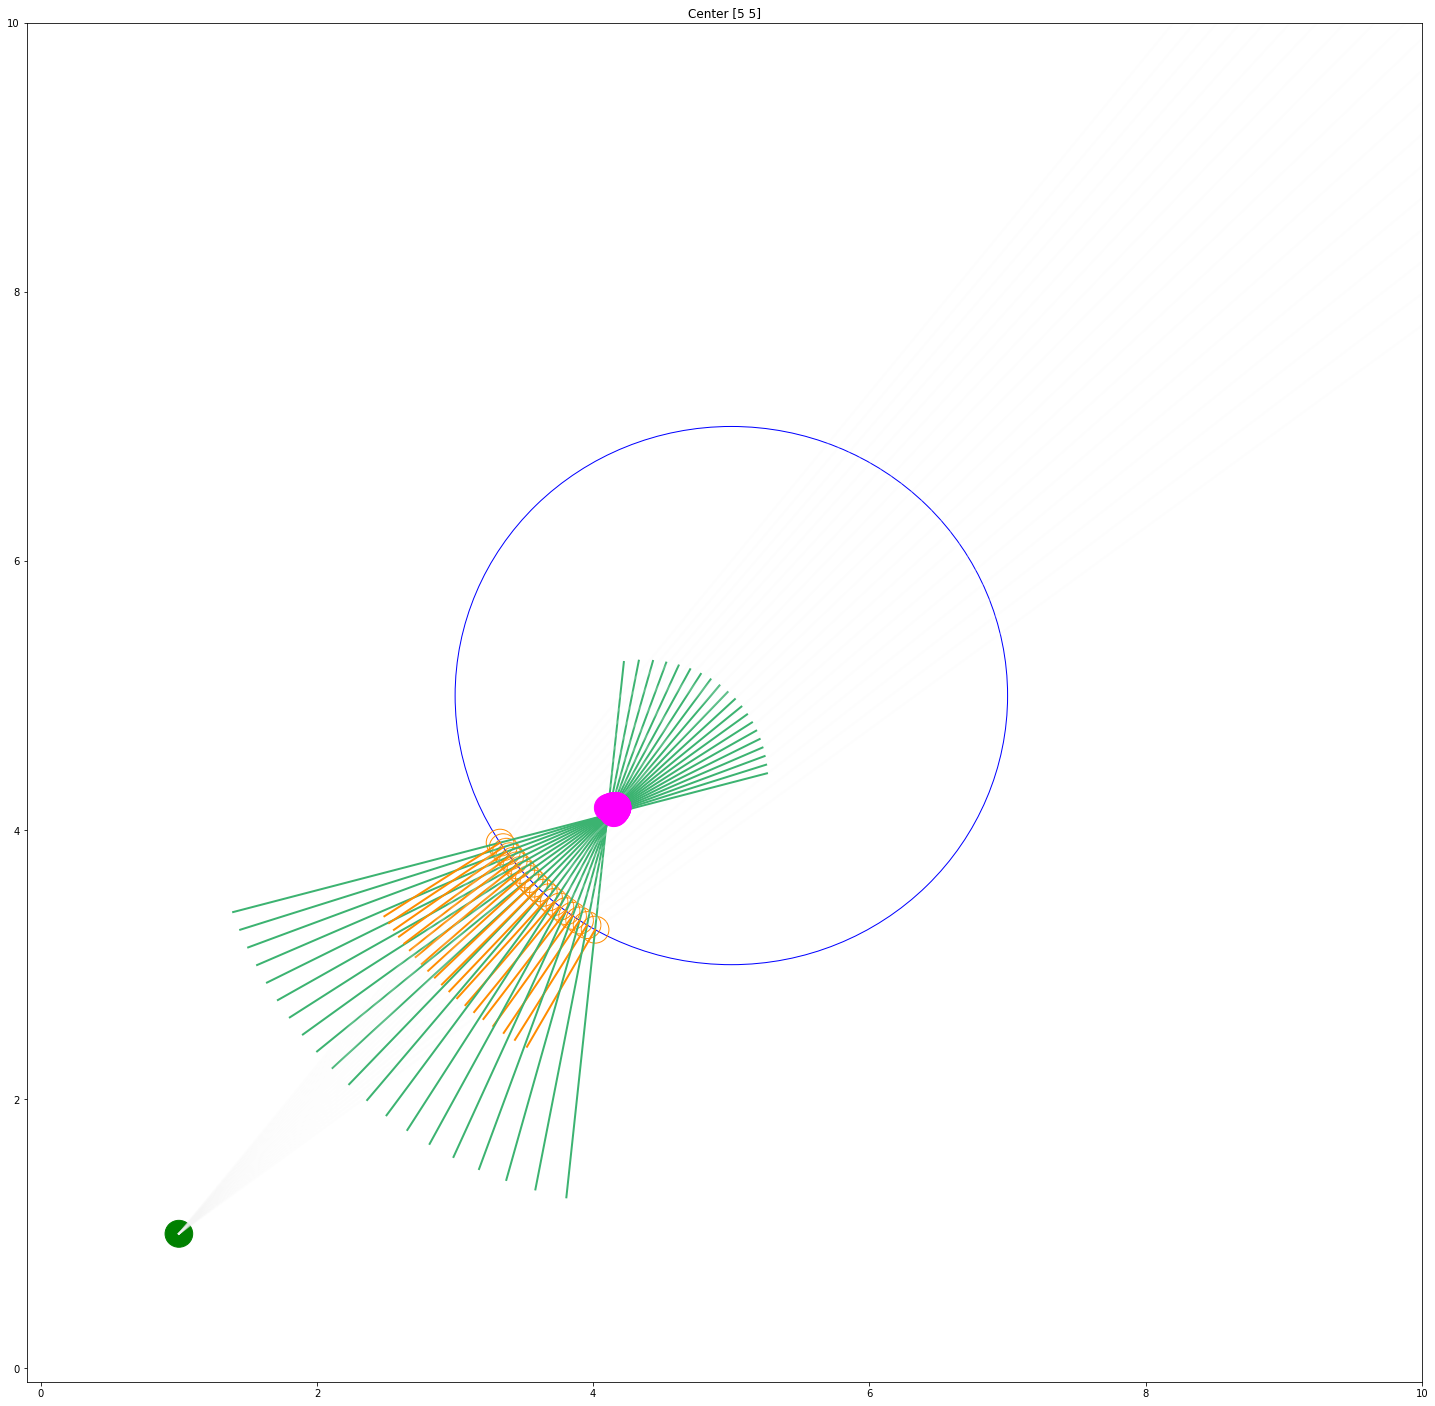

In [4]:
# del fig, ax
fig, ax = plt.subplots(figsize=(25, 25))
plt.xlim([-0.1, 10])
plt.ylim([-0.1, 10])

# Create a figure. Equal aspect so circles look circular
# ax.set_aspect('equal')
# Show the image
Cs_center = np.array([7, 3])
Cs_center = np.array([5, 5])
radius = 2
M = 0.75
pixel = np.array([1,1])

# big sphere (x-30)^2 + (y+70)^2 = 20
ax = add_circle(ax, Cs_center, radius, color='blue', fill=False) 
# ax = add_circle(ax, Cs_center[0]+1,Cs_center[1]+1,0.1, fill=False) # small point 
ax = add_circle(ax, pixel, 0.1, color='green', fill=True) # Pixel

M_LENS = [0.73, 0.75, 0.77]
M_LENS = [0.65, 0.63, 0.67]
M_LENS = [0.65, 0.64, 0.66]
# M_LENS = [0.65, 0.50, 0.80]
# M_LENS = [0.65, 0.60, 0.70]
# M_LENS = [0.70, 0.75, 0.80]
# M_LENS = [0.70, 0.75, 0.80]
# M_LENS = [0.70, 0.75, 0.80]

M_LENS = [1.0, 0.9, 0.95, 1.05, 1.10, 0.85, 1.15]
M_LENS = np.linspace(0.35, 2.35, 200)
M_LENS = np.linspace(0.35, 0.95, 200)
M_LENS = np.linspace(0.75, 1.25, 20) # for visualizing around the optical axis  
# M_LENS = np.linspace(1.25, 1.75, 20) # for visualizing away the optical axis  
# M_LENS = np.linspace(1.75, 2.25, 20) # for visualizing away the optical axis  
# M_LENS = np.linspace(1.0, 2.35, 25)
# M_LENS = [0.65, 0.60, 0.70, 0.55, 0.50, 0.60, 0.45, 0.40, 0.50, \
#           0.35, 0.30, 0.40]
principal_ray_idx = [0, 3, 6, 9]
principal_ray_idx = [0]

normal_rays = [] # tuple of rays
reflected_rays = [] # tuple of rays

for i in range (1):
    if i ==0:
        USE_I1 = True
    elif i ==1:
        USE_I1 = False
    else:
        break 
        
    for i, M in enumerate(M_LENS):

        #draw camera rays 
    #     incoming_dir = np.array((i1-pixel)/np.linalg.norm(i1-pixel))
        incoming_dir = np.array([1, M]/np.linalg.norm([1, M]))
        pt = pixel + 100* incoming_dir
#         ax = add_line(ax, pixel, pt, color='lightgrey') # normal
        ax = add_line(ax, pixel, pt, color='whitesmoke', alpha =0.2) # normal
#         ax = add_line(ax, pixel, pt, color='dimgrey') # normal

        i1, i2, d1, d2, success = ray_circle_intersection2d(pixel, [1, M], Cs_center, radius)

        if not USE_I1: 
            i1 = i2 
            d1 = d2

        if not success: 
            print("{} doeesn't lead to interscetion.".format(M))
            continue
        ax = add_circle(ax, i1,  0.1,'darkorange', fill=False) # Intesection points


        n = np.array((Cs_center-i1)/np.linalg.norm(Cs_center-i1))
        normal_rays.append((i1, n))
        incoming_dir = np.array((i1-pixel)/np.linalg.norm(i1-pixel))
        ref, ref_normalized = compute_reflected_ray(incoming_dir, n)
    #     ref, ref_normalized = compute_reflected_ray(np.array([1, M]), n)
        reflected_rays.append((i1, -ref_normalized))
        pt1 = i1 + 2.0 * ref_normalized
        pt2 = i1 + -2.0 * ref_normalized
        ax = add_line(ax, pt1, pt2, color='mediumseagreen') # reflected ray
        pt2 = i1 + -1.0 * n
        ax = add_line(ax, pt2, i1, color='darkorange') # normal

    #     if i in principal_ray_idx:
        if True:
#         if False:
            # get h'
            u1 = np.dot(n, normalize_vector([1, M]))
            # u = np.dot(normalize_vector(i1), n)
            theta = np.arccos(u1) # a\dot b = |a|.|b|.cos\theta; |n|, |i| are 1
            d1 = distance_between_two_points(pixel, i1)
            h = d1 * np.sin(theta)
            u = d1 * np.cos(theta)
            hyp = np.sqrt(h**2 + u**2)
            assert np.isclose(hyp, d1), "{} != {}".format(hyp, d1)
            # plot focal length
            if USE_I1: 
                f = -radius/2.
            else:
                f = radius/2.
            v_inv = 1/f - 1/u
            v = 1./v_inv
            # print("d {}, h {}, u {}, v {}".format(d1,h, u, v))

            h_prime = v/u * h
            t_1 = np.sqrt(h_prime**2 + v**2)
            # print("h_prime: {}, v: {}, t_1: {}".format(h_prime, v, t_1))
            v_viewpoint = i1 - t_1*ref_normalized 
            # v_viewpoint = i1 + t_1*ref_normalized 
            ax = add_circle(ax, v_viewpoint,  0.1,'magenta', fill=True, zorder=10) # Pixel

        if i not in  principal_ray_idx and False:
            _dir = np.array((i1-v_viewpoint)/np.linalg.norm(i1-v_viewpoint))
            pt = v_viewpoint + 8.0 * _dir 
            ax = add_line(ax, v_viewpoint, pt, color='orange') # normal


plt.title("Center {}".format(Cs_center))
plt.show()

In [5]:
import torch

In [6]:
shape = torch.Size([1, 64, 192, 3])
nabla = torch.zeros(shape)

In [7]:
nabla[..., 0].shape

torch.Size([1, 64, 192])

[0.35       0.38979592 0.42959184 0.46938776 0.50918367 0.54897959
 0.58877551 0.62857143 0.66836735 0.70816327 0.74795918 0.7877551
 0.82755102 0.86734694 0.90714286 0.94693878 0.98673469 1.02653061
 1.06632653 1.10612245 1.14591837 1.18571429 1.2255102  1.26530612
 1.30510204 1.34489796 1.38469388 1.4244898  1.46428571 1.50408163
 1.54387755 1.58367347 1.62346939 1.66326531 1.70306122 1.74285714
 1.78265306 1.82244898 1.8622449  1.90204082 1.94183673 1.98163265
 2.02142857 2.06122449 2.10102041 2.14081633 2.18061224 2.22040816
 2.26020408 2.3       ]
0.35 doeesn't lead to interscetion.
0.3897959183673469 doeesn't lead to interscetion.
0.4295918367346938 doeesn't lead to interscetion.
2.2204081632653057 doeesn't lead to interscetion.
2.2602040816326525 doeesn't lead to interscetion.
2.3 doeesn't lead to interscetion.
0.35 doeesn't lead to interscetion.
0.3897959183673469 doeesn't lead to interscetion.
0.4295918367346938 doeesn't lead to interscetion.
2.2204081632653057 doeesn't lead t

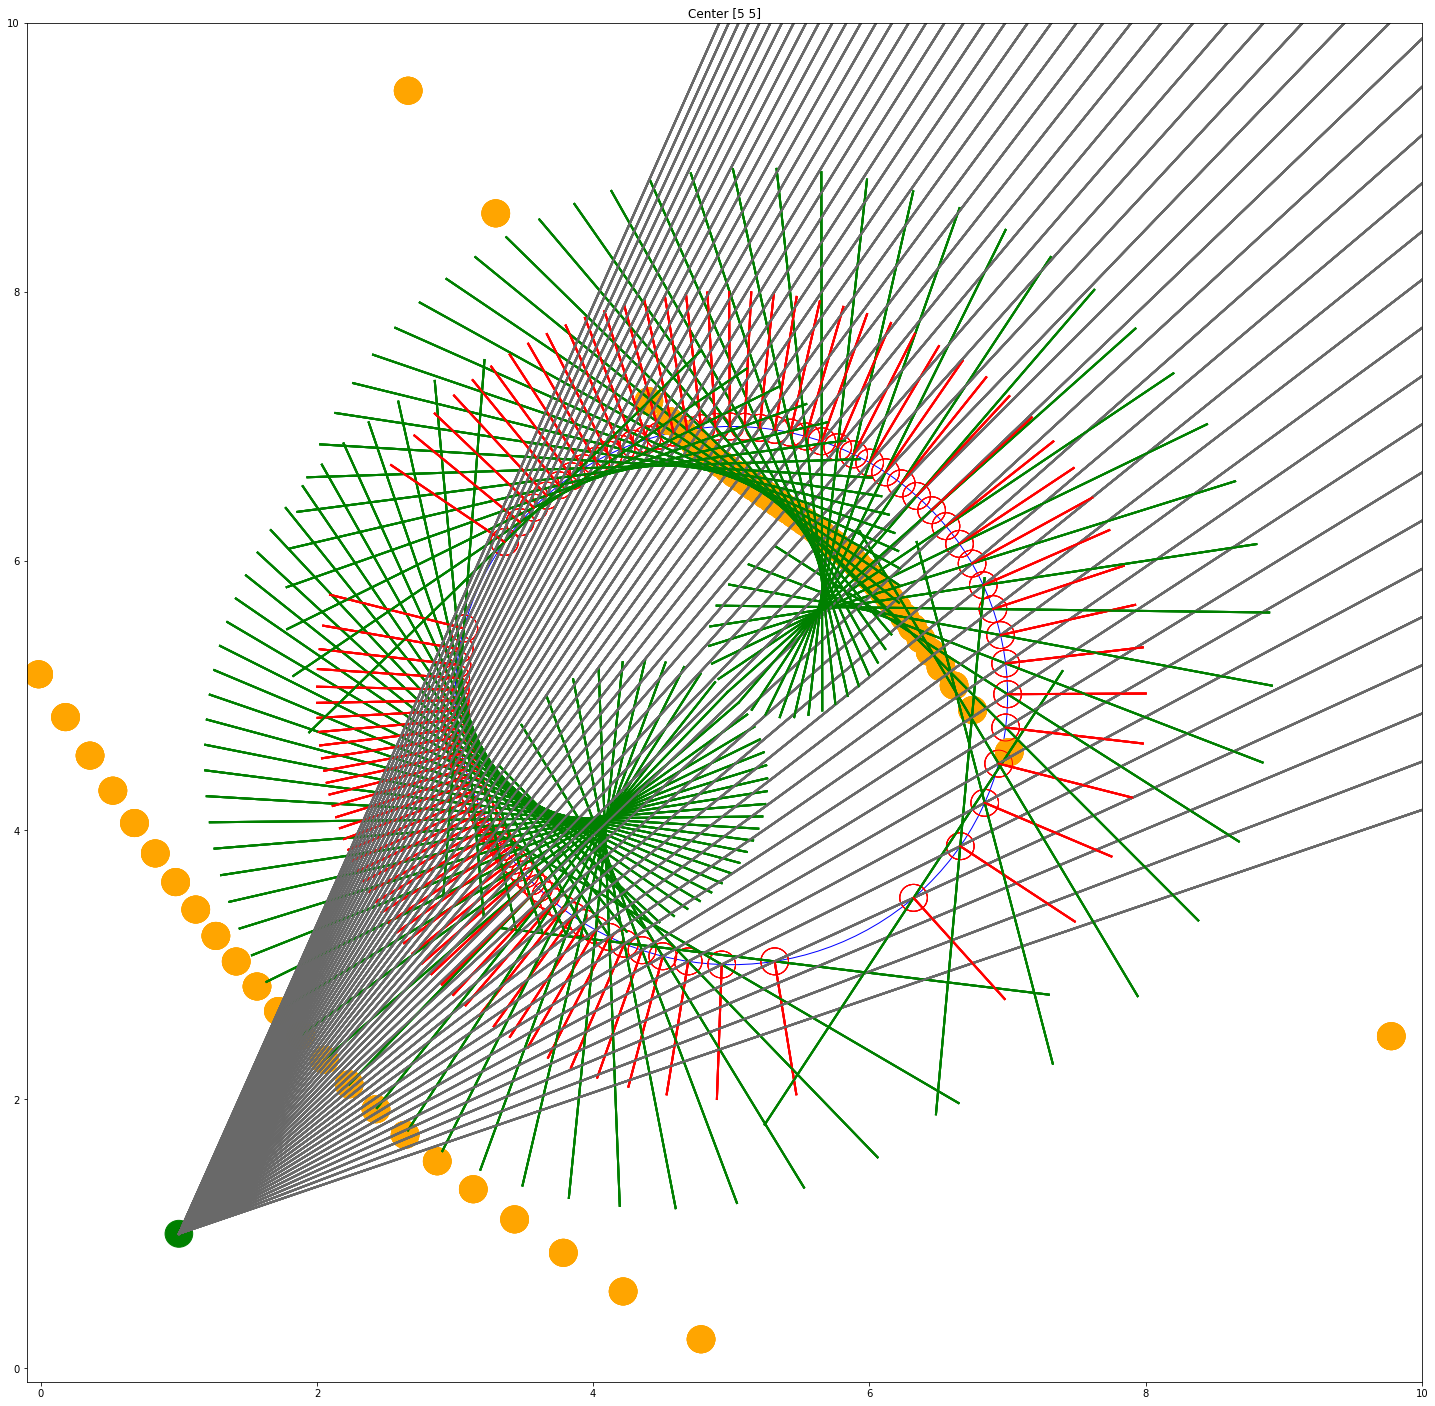

In [8]:
# del fig, ax
fig, ax = plt.subplots(figsize=(25, 25))
plt.xlim([-0.1, 10])
plt.ylim([-0.1, 10])

# Create a figure. Equal aspect so circles look circular
# ax.set_aspect('equal')
# Show the image
Cs_center = np.array([7, 3])
Cs_center = np.array([5, 5])
radius = 2
M = 0.75
pixel = np.array([1,1])

# big sphere (x-30)^2 + (y+70)^2 = 20
ax = add_circle(ax, Cs_center, radius, color='blue', fill=False) 
# ax = add_circle(ax, Cs_center[0]+1,Cs_center[1]+1,0.1, fill=False) # small point 
ax = add_circle(ax, pixel, 0.1, color='green', fill=True) # Pixel

M_LENS = [0.73, 0.75, 0.77]
M_LENS = [0.65, 0.63, 0.67]
M_LENS = [0.65, 0.64, 0.66]
# M_LENS = [0.65, 0.50, 0.80]
# M_LENS = [0.65, 0.60, 0.70]
# M_LENS = [0.70, 0.75, 0.80]
# M_LENS = [0.70, 0.75, 0.80]
# M_LENS = [0.70, 0.75, 0.80]

M_LENS = [1.0, 0.9, 0.95, 1.05, 1.10, 0.85, 1.15]
M_LENS = np.linspace(0.35, 2.30, 50)
print(M_LENS)
# M_LENS = [0.65, 0.60, 0.70, 0.55, 0.50, 0.60, 0.45, 0.40, 0.50, \
#           0.35, 0.30, 0.40]
principal_ray_idx = [0, 3, 6, 9]
principal_ray_idx = [0]

normal_rays = [] # tuple of rays
reflected_rays = [] # tuple of rays

PIXLES = [np.array([1,1]), np.array([1,1]), np.array([1,1]), np.array([1,1])]
PIXELS = [np.array([1,1]), np.array([1,1]), np.array([1,1]), np.array([1,1])]
for pixel in PIXELS: 
    for i in range (2):
        if i ==0:
            USE_I1 = True
        elif i ==1:
            USE_I1 = False
        else:
            break 

        for i, M in enumerate(M_LENS):

            #draw camera rays 
        #     incoming_dir = np.array((i1-pixel)/np.linalg.norm(i1-pixel))
            incoming_dir = np.array([1, M]/np.linalg.norm([1, M]))
            pt = pixel + 100* incoming_dir
            ax = add_line(ax, pixel, pt, color='dimgrey') # normal

            i1, i2, d1, d2, success = ray_circle_intersection2d(pixel, [1, M], Cs_center, radius)

            if not USE_I1: 
                i1 = i2 
                d1 = d2

            if not success: 
                print("{} doeesn't lead to interscetion.".format(M))
                continue
            ax = add_circle(ax, i1,  0.1,'red', fill=False) # Intesection points


            n = np.array((Cs_center-i1)/np.linalg.norm(Cs_center-i1))
            normal_rays.append((i1, n))
            incoming_dir = np.array((i1-pixel)/np.linalg.norm(i1-pixel))
            ref, ref_normalized = compute_reflected_ray(incoming_dir, n)
        #     ref, ref_normalized = compute_reflected_ray(np.array([1, M]), n)
            reflected_rays.append((i1, -ref_normalized))
            pt1 = i1 + 2.0 * ref_normalized
            pt2 = i1 + -2.0 * ref_normalized
            ax = add_line(ax, pt1, pt2, color='green') # reflected ray
            pt2 = i1 + -1.0 * n
            ax = add_line(ax, pt2, i1, color='red') # normal

        #     if i in principal_ray_idx:
            if True:
                # get h'
                u = np.dot(n, normalize_vector([1, M]))
        #         u = np.dot(normalize_vector(i1), n)
                theta = np.arccos(u)
                h = d1 * np.sin(theta)
                u = d1 * np.cos(theta)
                hyp = np.sqrt(h**2 + u**2)
                assert np.isclose(hyp, d1), "{} != {}".format(hyp, d1)
                # plot focal length         
                f = radius/2.
                v_inv = 1/f - 1/u
                v = 1./v_inv
    #             print("d {}, h {}, u {}, v {}".format(d1,h, u, v))

                h_prime = v/u * h
                t_1 = np.sqrt(h_prime**2 + v**2)
    #             print("h_prime: {}, v: {}, t_1: {}".format(h_prime, v, t_1))
                v_viewpoint = i1 + t_1*ref_normalized 
                ax = add_circle(ax, v_viewpoint,  0.1,'orange', fill=True) # Pixel

            if i not in  principal_ray_idx and False:
                _dir = np.array((i1-v_viewpoint)/np.linalg.norm(i1-v_viewpoint))
                pt = v_viewpoint + 8.0 * _dir 
                ax = add_line(ax, v_viewpoint, pt, color='orange') # normal

        # plot the closest of all intersected rays, and draw cones
        # point = locate(normal_rays)
        visualize_interection = False
        if visualize_interection:
            point = locate(reflected_rays)
            print("Found point {} with error {} and success {}".format(point['x'], point['cost'], point['success']))
            ax = add_circle(ax, point['x'],  0.1,'hotpink', fill=True) # Pixel
            for ray in normal_rays: 
                _dir = np.array((ray[0]-point['x'])/np.linalg.norm(ray[0]-point['x']))
                pt = point['x'] + 5.0 * _dir 
                ax = add_line(ax, point['x'], pt, color='hotpink') #Virtual Cones


plt.title("Center {}".format(Cs_center))
plt.show()

0.35 doeesn't lead to interscetion.
0.3908163265306122 doeesn't lead to interscetion.
0.43163265306122445 doeesn't lead to interscetion.
f -1.0, d 7.32158557398654, h 6.984727102082583, u 2.195268235692593, v -0.6870372293538467
h_prime: -2.1859595460750425, v: -0.6870372293538467, t_1: 2.2913837067577347
f -1.0, d 6.785772013370872, h 5.876842246873641, u 3.3925546455154634, v -0.7723420467811504
h_prime: -1.3379098773133187, v: -0.7723420467811504, t_1: 1.5448349675737651
f -1.0, d 6.43904631099426, h 5.023056223062608, u 4.028675163758032, v -0.8011404659407987
h_prime: -0.9988826200714016, v: -0.8011404659407987, t_1: 1.2804657491899376
f -1.0, d 6.173370397703547, h 4.298559011870756, u 4.430901994933669, v -0.815868524062325
h_prime: -0.791500015260956, v: -0.815868524062325, t_1: 1.136711802839106
f -1.0, d 5.956002553636617, h 3.6620388038770377, u 4.697173428544527, v -0.8244743621477795
h_prime: -0.6427816968900996, v: -0.8244743621477795, t_1: 1.0454311472765214
f -1.0, d 5.

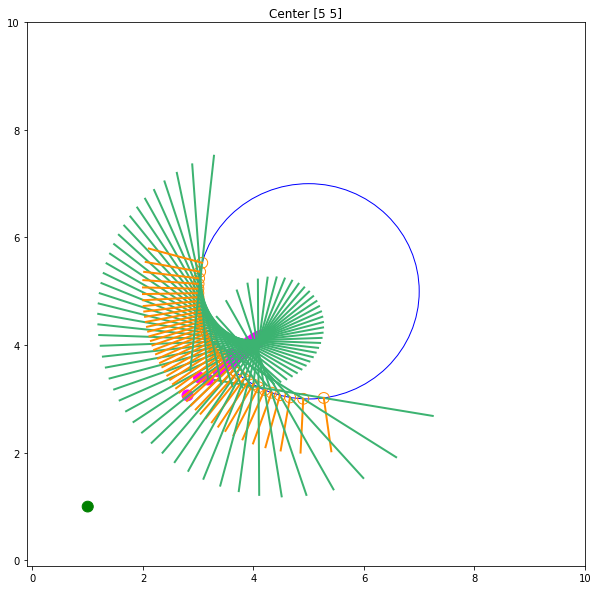

In [9]:
# del fig, ax
fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim([-0.1, 10])
plt.ylim([-0.1, 10])

# Create a figure. Equal aspect so circles look circular
# ax.set_aspect('equal')
# Show the image
Cs_center = np.array([7, 3])
Cs_center = np.array([5, 5])
# Cs_center = np.array([3, 3])
radius = 2
M = 0.75
pixel = np.array([1,1])

# big sphere (x-30)^2 + (y+70)^2 = 20
ax = add_circle(ax, Cs_center, radius, color='blue', fill=False) 
# ax = add_circle(ax, Cs_center[0]+1,Cs_center[1]+1,0.1, fill=False) # small point 
ax = add_circle(ax, pixel, 0.1, color='green', fill=True) # Pixel

M_LENS = [0.73, 0.75, 0.77]
M_LENS = [0.65, 0.63, 0.67]
M_LENS = [0.65, 0.64, 0.66]
# M_LENS = [0.65, 0.50, 0.80]
# M_LENS = [0.65, 0.60, 0.70]
# M_LENS = [0.70, 0.75, 0.80]
# M_LENS = [0.70, 0.75, 0.80]
# M_LENS = [0.70, 0.75, 0.80]

M_LENS = [1.0, 0.9, 0.95 , 1.05, 1.10, 0.85, 1.15]
M_LENS = [1.0] #, 0.9, 0.95 , 1.05, 1.10, 0.85, 1.15]
M_LENS = np.linspace(0.35, 2.35, 50)
# M_LENS = [0.65, 0.60, 0.70, 0.55, 0.50, 0.60, 0.45, 0.40, 0.50, \
#           0.35, 0.30, 0.40]
principal_ray_idx = [0, 3, 6, 9]
principal_ray_idx = [0]

normal_rays = [] # tuple of rays
reflected_rays = [] # tuple of rays

for i in range (1):
    if i ==0:
        USE_I1 = True
    elif i ==1:
        USE_I1 = False
    else:
        break 
        
    for i, M in enumerate(M_LENS):

        #draw camera rays 
    #     incoming_dir = np.array((i1-pixel)/np.linalg.norm(i1-pixel))
        incoming_dir = np.array([1, M]/np.linalg.norm([1, M]))
        pt = pixel + 100* incoming_dir
#         ax = add_line(ax, pixel, pt, color='lightgrey') # normal
#         ax = add_line(ax, pixel, pt, color='dimgrey') # normal

        i1, i2, d1, d2, success = ray_circle_intersection2d(pixel, [1, M], Cs_center, radius)

        if not USE_I1: 
            i1 = i2 
            d1 = d2

        if not success: 
            print("{} doeesn't lead to interscetion.".format(M))
            continue
            
        ax = add_circle(ax, i1,  0.1,'darkorange', fill=False) # Intesection points

        n = np.array((Cs_center-i1)/np.linalg.norm(Cs_center-i1))
        normal_rays.append((i1, n))
        incoming_dir = np.array((i1-pixel)/np.linalg.norm(i1-pixel))
        ref, ref_normalized = compute_reflected_ray(incoming_dir, n)
    #     ref, ref_normalized = compute_reflected_ray(np.array([1, M]), n)
        reflected_rays.append((i1, -ref_normalized))
        pt1 = i1 + 2.0 * ref_normalized
        pt2 = i1 + -2.0 * ref_normalized
        ax = add_line(ax, pt1, pt2, color='mediumseagreen') # reflected ray
        pt2 = i1 + -1.0 * n
        ax = add_line(ax, pt2, i1, color='darkorange') # normal

    #     if i in principal_ray_idx:
        if True:
            # get h'
            u = np.dot(n, normalize_vector([1, M]))
            # u = np.dot(normalize_vector(i1), n)
            theta = np.arccos(u)
            d1 = distance_between_two_points(pixel, i1)
            h = d1 * np.sin(theta)
            u = d1 * np.cos(theta)
            hyp = np.sqrt(h**2 + u**2)
            assert np.isclose(hyp, d1), "{} != {}".format(hyp, d1)
            # plot focal length         
            f = -radius/2.
            v_inv = 1/f - 1/u
            v = 1./v_inv
            print("f {}, d {}, h {}, u {}, v {}".format(f, d1,h, u, v))

            h_prime = v/u * h
            t_1 = np.sqrt(h_prime**2 + v**2)
            print("h_prime: {}, v: {}, t_1: {}".format(h_prime, v, t_1))
            v_viewpoint = i1 - t_1 * ref_normalized 
            # v_viewpoint = i1 + t_1*ref_normalized 
            ax = add_circle(ax, v_viewpoint,  0.1,'magenta', fill=True) # Virtual Viewpoint

        if i not in  principal_ray_idx and False:
            _dir = np.array((i1-v_viewpoint)/np.linalg.norm(i1-v_viewpoint))
            pt = v_viewpoint + 8.0 * _dir 
            ax = add_line(ax, v_viewpoint, pt, color='orange') # normal

    # plot the closest of all intersected rays, and draw cones
    # point = locate(normal_rays)
    visualize_interection = False
    if visualize_interection:
        point = locate(reflected_rays)
        print("Found point {} with error {} and success {}".format(point['x'], point['cost'], point['success']))
        ax = add_circle(ax, point['x'],  0.1,'hotpink', fill=True) # Pixel
        for ray in normal_rays: 
            _dir = np.array((ray[0]-point['x'])/np.linalg.norm(ray[0]-point['x']))
            pt = point['x'] + 5.0 * _dir 
            ax = add_line(ax, point['x'], pt, color='hotpink') #Virtual Cones


plt.title("Center {}".format(Cs_center))
plt.show()

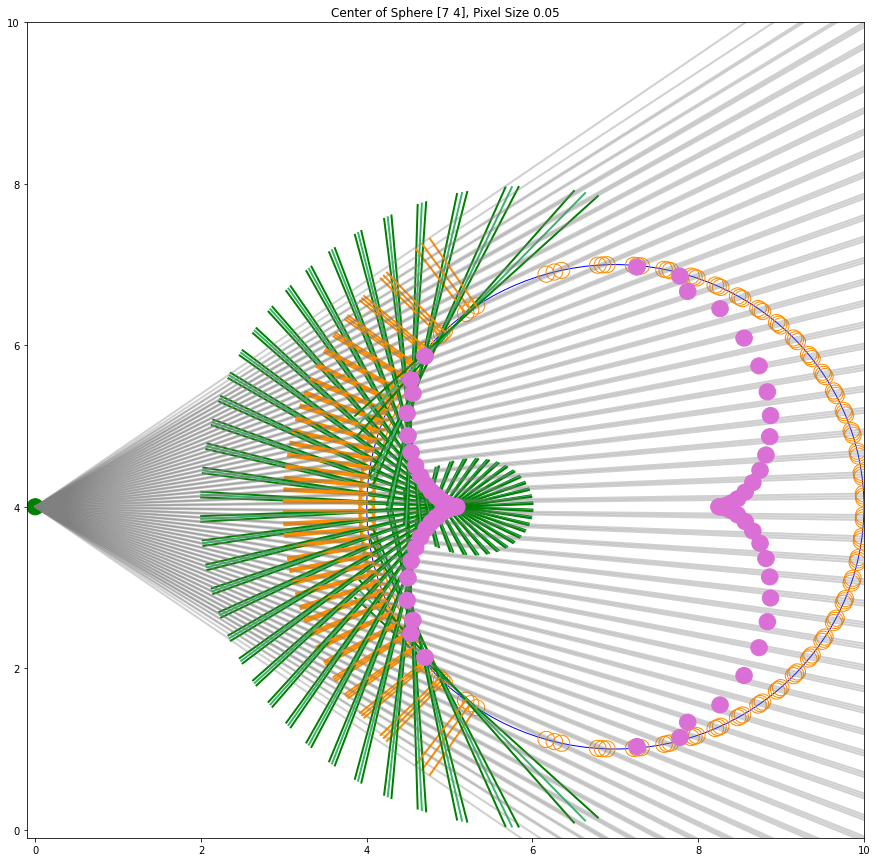

In [68]:
# del fig, ax
fig, ax = plt.subplots(figsize=(15, 15))
# fig, ax = plt.subplots(figsize=(20, 20))
plt.xlim([-0.1, 10])
plt.ylim([-0.1, 10])

# Create a figure. Equal aspect so circles look circular
# ax.set_aspect('equal')

# M_LENS = [0.73, 0.75, 0.77]
# M_LENS = [0.65, 0.63, 0.67]
# M_LENS = [0.65, 0.64, 0.66]
# M_LENS = [0.65, 0.50, 0.80]
# M_LENS = [0.65, 0.60, 0.70]
# M_LENS = [0.70, 0.75, 0.80]
# M_LENS = [0.70, 0.75, 0.80]
# M_LENS = [0.70, 0.75, 0.80]
M_LENS = [0.70] #, 0.55, 0.90] 

# M_LENS = [1.0, 0.9, 0.95, 1.05, 1.10, 0.85, 1.15]
# M_LENS = np.linspace(0.40, 2.55, 75)
M_LENS = np.linspace(0.0, 1.55, 40)
M_LENS = np.linspace(0.7, 1.55, 200)
M_LENS = np.linspace(-0.1, 1.55, 300)
M_LENS = np.linspace(-0.1, 1.55, 30)
M_LENS = np.linspace(0.1, 3.5, 100)
M_LENS = np.linspace(-0.65, 0.65, 50)
# M_LENS = [0.60, 0.80 , 0.30,] #1.05, 1.10, 0.85, 1.15]
# print(M_LENS)
# M_LENS = np.linspace(1.0, 2.35, 25)
# M_LENS = [0.65, 0.60, 0.70, 0.55, 0.50, 0.60, 0.45, 0.40, 0.50, \
#           0.35, 0.30, 0.40]
principal_ray_idx = [0, 3, 6, 9]
principal_ray_idx = [0]

normal_rays = dict() # tuple of rays
reflected_rays = dict() # tuple of rays

PIXEL_SIZE = 0.05
# PIXEL_SIZE = 0.001

Cs_center = np.array([7, 7])
Cs_center = np.array([7,4])
# Cs_center = np.array([5, 5])
# M_LENS = np.linspace(0.40, 2.55, 500)


radius = 3
pixel = np.array([0,4])

ax = add_circle(ax, Cs_center, radius, color='blue', fill=False) 
ax = add_circle(ax, pixel, 0.1, color='green', fill=True) # Pixel

i_MOST_NOROMAL_REFL_RENDER = 0
MOST_NOROMAL_REFL_RENDER = 200

for i in range (2):
    if i ==0:
        USE_I1 = True
    elif i ==1:
        USE_I1 = False
    else:
        break 
        
    for i, _M in enumerate(M_LENS):

        #draw camera rays 
        NEW_MS = [_M, _M-PIXEL_SIZE, _M+PIXEL_SIZE]
#         NEW_MS = [_M] #, _M-PIXEL_SIZE, _M+PIXEL_SIZE]
        normal_rays[_M] = []
        reflected_rays[_M] = []
        for j, M in enumerate(NEW_MS):
            incoming_dir = np.array([1, M]/np.linalg.norm([1, M]))
            pt = pixel + 100* incoming_dir
#             ax = add_line(ax, pixel, pt, color='dimgrey', alpha =0.2, zorder=1) # normal
            ax = add_line(ax, pixel, pt, color='grey', alpha =0.2) # normal
            

            i1, i2, d1, d2, success = ray_circle_intersection2d(pixel, [1, M], Cs_center, radius)

            if not USE_I1: 
                i1 = i2 
                d1 = d2

            if not success: 
#                 print("{} doeesn't lead to interscetion.".format(M))
                continue
            ax = add_circle(ax, i1,  0.1,'darkorange', fill=False) # Intesection points


            n = np.array((Cs_center-i1)/np.linalg.norm(Cs_center-i1))
            incoming_dir = np.array((i1-pixel)/np.linalg.norm(i1-pixel))
            ref, ref_normalized = compute_reflected_ray(incoming_dir, n)
            normal_rays[_M].append((i1, n))
            if USE_I1: 
                reflected_rays[_M].append((i1, -ref_normalized))
            else: 
                reflected_rays[_M].append((i1, ref_normalized))
            
            pt1 = i1 + 2.0 * ref_normalized
            pt2 = i1 + -2.0 * ref_normalized
            if USE_I1: #i_MOST_NOROMAL_REFL_RENDER < MOST_NOROMAL_REFL_RENDER:
                if j in principal_ray_idx:
                    ax = add_line(ax, pt1, pt2, color='mediumseagreen') # reflected ray
                else:
                    ax = add_line(ax, pt1, pt2, color='green') # reflected ray
            pt2 = i1 + -1.0 * n
            if USE_I1: #if i_MOST_NOROMAL_REFL_RENDER < MOST_NOROMAL_REFL_RENDER:
                ax = add_line(ax, pt2, i1, color='darkorange') # normal

            if i not in  principal_ray_idx and False:
                _dir = np.array((i1-v_viewpoint)/np.linalg.norm(i1-v_viewpoint))
                pt = v_viewpoint + 8.0 * _dir 
                ax = add_line(ax, v_viewpoint, pt, color='orange') # normal

        # plot the closest of all intersected rays, and draw cones
        visualize_interection = True
        visualize_virtual_cameras = False
        if visualize_interection:
#             print(len(reflected_rays[_M]))
            if len(reflected_rays[_M]) > 1:
#                 import time; t = time.time()
                point = locate_pinv(reflected_rays[_M])
#                 elapsed = time.time()-t
#                 print(f"Elapsed time {elapsed} seconds")
    #             print("Found point {} with error {} and success {}".format(point['x'], point['cost'], point['success']))
                ax = add_circle(ax, point['x'],  0.1,'orchid', fill=True, zorder=10) # Pixel
                if visualize_virtual_cameras:
                    for ray in reflected_rays[_M][1:]: 
                        _dir = np.array((ray[0]-point['x'])/np.linalg.norm(ray[0]-point['x']))
                        pt = point['x'] + 5.0 * _dir 
                        ax = add_line(ax, point['x'], pt, color='orchid', zorder=10) #Virtual Cones


plt.title("Center of Sphere {}, Pixel Size {}".format(Cs_center, PIXEL_SIZE))
plt.show()

In [11]:
import time
import tqdm

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares


def find_closest_point(pts, view_dirs):
    """
    From: https://math.stackexchange.com/questions/2598811/calculate-the-point-closest-to-multiple-rays
    Determine the closest point to an arbitrary number of rays, and optionally plot the results

    :param rays:    list of ray tuples (S, D) where S is the starting point & D is a unit vector
    :return:        scipy.optimize.OptimizeResult object from scipy.optimize.least_squares call
    """

    # Generate a starting position, the dimension-wise mean of each ray's starting position
    starting_P = torch.mean(pts, axis=0)

    # Start the least squares algorithm, passing the li
    st of rays to our error function
    ans = least_squares(distance, starting_P, kwargs={'pts': pts, 'view_dirs': view_dirs})
    return ans


def distance(P, pts, view_dirs):
    """
    Calculate the distance between a point and each ray

    :param P:       1xd array representing coordinates of a point
    :param rays:    list of ray tuples (S, D) where S is the starting point & D is a unit vector
    :return:        nx1 array of closest distance from point P to each ray in rays
    """

    dims = 3 # we are in a 3D world 
    # Generate array to hold calculated error distances
    errors = torch.full([len(pts)*dims], torch.inf)
    P = torch.tensor(P).float()

    # For each ray, calculate the error and put in the errors array
    for i in range(len(pts)):
        S, D = pts[i], view_dirs[i]
#         print("i --> ", S, D, P)
        t_P = D.dot((P - S).T)/(D.dot(D.T))
        if t_P > 0:
            errors[i*dims:(i+1)*dims] = (P - (S + t_P * D)).T
        else:
            errors[i*dims:(i+1)*dims] = (P - S).T

    # Convert the error array to a vector (vs a nx1 matrix)
    
    return errors.ravel()

pts = torch.tensor([[0,0,0],[1,1,1], [2,2,2], [1.5, 1.5, 1.5], [0.5, 0.5, 0.5], [1.75,1.75,1.75]]).float()
# view_dirs = torch.tensor([[0,1,0],[1,0,0], [1,0,0], [1,0,0], [1,0,0]]).float()

MAX_ITERS = 1000
pts = torch.rand([MAX_ITERS, 5, 3])
view_dirs = torch.rand(pts.shape)

st = time.time()
for i in tqdm.tqdm(range(MAX_ITERS)):
    point = find_closest_point(pts[i], view_dirs[i])
print("Execution Time per iteration over {} iters: {}".format(MAX_ITERS, (time.time()- st)/MAX_ITERS))
point

SyntaxError: invalid syntax (3960831940.py, line 19)